In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
!pip install numpy==1.24.3
!pip install glfw


In [3]:
!pip install box2d

In [4]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [8]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [10]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [11]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [12]:
def train(env, policy, optimizer, discount_factor):

    policy.train()

    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = actor(state)
        value_pred = critic(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [13]:
"""
def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:

        returns = (returns - returns.mean()) / returns.std()

    return returns
"""
class AdaptiveKalman:
    def __init__(self, Q=1, R=1e-2, alpha=0.9):
        self.x = 0.0  # 均值估计
        self.P = 1.0  # 协方差
        self.Q = Q
        self.R = R
        self.alpha = alpha

    def update(self, z):
        self.P += self.Q
        K = self.P / (self.P + self.R)
        residual = z - self.x
        self.x += K * residual
        self.P *= (1 - K)
        self.R = self.alpha * self.R + (1 - self.alpha) * (residual ** 2)
        return self.x, self.P

def calculate_returns(rewards, discount_factor, normalize=True):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)

    if normalize:
        kalman = AdaptiveKalman()
        for r in returns:
            mean_estimate, var_estimate = kalman.update(r.item())
        std_estimate = (var_estimate ** 0.5) + 1e-8
        returns = (returns - mean_estimate) / std_estimate

    return returns

In [14]:
def calculate_advantages(returns, values, normalize = True):

    advantages = returns - values

    if normalize:

        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

In [15]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):

    advantages = advantages.detach()
    returns = returns.detach()

    policy_loss = - (advantages * log_prob_actions).sum()

    value_loss = F.smooth_l1_loss(returns, values).sum()

    optimizer.zero_grad()

    policy_loss.backward()
    value_loss.backward()

    optimizer.step()

    return policy_loss.item(), value_loss.item()

In [16]:
def evaluate(env, policy):

    policy.eval()

    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [17]:
MAX_EPISODES = 3_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):

    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)

    # test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    # test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    # mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:

        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f}')

    if mean_train_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| Episode:  10 | Mean Train Rewards:  -157.0
| Episode:  20 | Mean Train Rewards:  -162.1
| Episode:  30 | Mean Train Rewards:  -139.6
| Episode:  40 | Mean Train Rewards:  -199.4
| Episode:  50 | Mean Train Rewards:  -204.0
| Episode:  60 | Mean Train Rewards:  -191.7
| Episode:  70 | Mean Train Rewards:  -161.7
| Episode:  80 | Mean Train Rewards:  -153.9
| Episode:  90 | Mean Train Rewards:  -145.6
| Episode: 100 | Mean Train Rewards:  -146.0
| Episode: 110 | Mean Train Rewards:  -173.7
| Episode: 120 | Mean Train Rewards:  -181.3
| Episode: 130 | Mean Train Rewards:  -147.1
| Episode: 140 | Mean Train Rewards:  -118.4
| Episode: 150 | Mean Train Rewards:  -103.7
| Episode: 160 | Mean Train Rewards:  -108.1
| Episode: 170 | Mean Train Rewards:  -107.8
| Episode: 180 | Mean Train Rewards:   -89.1
| Episode: 190 | Mean Train Rewards:   -84.3
| Episode: 200 | Mean Train Rewards:   -99.3
| Episode: 210 | Mean Train Rewards:  -105.0
| Episode: 220 | Mean Train Rewards:   -92.7
| Episode:

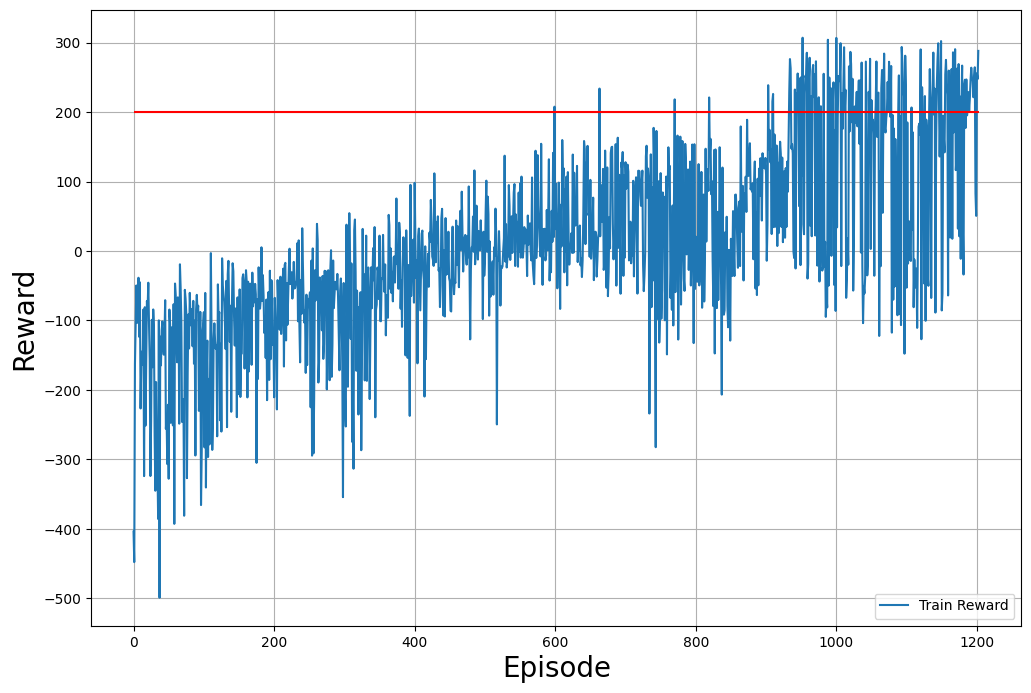

In [18]:
plt.figure(figsize=(12,8))
# plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(train_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [19]:
# prompt: train_rewads to txt file and save it

with open("train_rewards.txt", "w") as f:
  for reward in train_rewards:
    f.write(str(reward) + "\n")